# setup

In [ ]:
# import pdb

In [ ]:
import pickle
import numpy as np

import torch
import matplotlib.pyplot as plt

from torch import nn, Tensor
# from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

# from datasets import load_dataset

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
import numpy as np
import torch

In [ ]:
from huggingface_hub import hf_hub_download, notebook_login
notebook_login()

# load labels

In [ ]:
import json
with open('gemma-2-2b-20-gemmascope-res-16k-explanations.json', 'rb') as f:
    feat_labels_allData = json.load(f)

In [ ]:
feat_labels_lst = [0 for i in range(feat_labels_allData['explanationsCount'])]
feat_labels_dict = {}
for f_dict in feat_labels_allData['explanations']:
    feat_labels_lst[int(f_dict['index'])] = f_dict['description']
    feat_labels_dict[int(f_dict['index'])] = f_dict['description']
    if int(f_dict['index']) == 0:
        print(f_dict['description'])

mentions of the letter 'Z' and variations of 'Z' in different contexts


In [ ]:
len(feat_labels_dict)

16383

## search for features

In [ ]:
def find_indices_with_keyword(f_dict, keyword):
    """
    Find all indices of fList which contain the keyword in the string at those indices.

    Args:
    fList (list of str): List of strings to search within.
    keyword (str): Keyword to search for within the strings of fList.

    Returns:
    list of int: List of indices where the keyword is found within the strings of fList.
    """
    filt_dict = {}
    for index, string in f_dict.items():
        # split_list = string.split(',')
        # no_space_list = [i.replace(' ', '').lower() for i in split_list]
        # if keyword in no_space_list:
        if keyword in string:
            filt_dict[index] = string
    return filt_dict

In [ ]:
keyword = "number"
number_feats = find_indices_with_keyword(feat_labels_dict, keyword)

In [ ]:
keyword = "month"
month_feats = find_indices_with_keyword(feat_labels_dict, keyword)

# load model

In [ ]:
torch.set_grad_enabled(False) # avoid blowing up mem

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b",
    device_map='auto',
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
tokenizer =  AutoTokenizer.from_pretrained("google/gemma-2-2b")

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

# load transformerlens

In [ ]:
%%capture
!pip install transformer_lens

In [ ]:
%%capture
from transformer_lens import HookedTransformer

# uses a lot of memory, use A100
model_2 = HookedTransformer.from_pretrained(
    "gemma-2-2b"
)

In [ ]:
from transformer_lens.hook_points import HookPoint
from functools import partial
from jaxtyping import Float, Int

# test prompts

In [ ]:
prompt = "thirteen fourteen fifteen sixteen "
inputs = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to("cuda")
outputs = model.generate(input_ids=inputs, max_new_tokens=1)
print(tokenizer.decode(outputs[0, -1]))

1


# load sae

In [ ]:
path_to_params = hf_hub_download(
    repo_id="google/gemma-scope-2b-pt-res",
    filename="layer_20/width_16k/average_l0_71/params.npz",
    force_download=False,
)

params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

In [ ]:
params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v).cuda() for k, v in params.items()}

In [ ]:
import torch.nn as nn
class JumpReLUSAE(nn.Module):
  def __init__(self, d_model, d_sae):
    # Note that we initialise these to zeros because we're loading in pre-trained weights.
    # If you want to train your own SAEs then we recommend using blah
    super().__init__()
    self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
    self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
    self.threshold = nn.Parameter(torch.zeros(d_sae))
    self.b_enc = nn.Parameter(torch.zeros(d_sae))
    self.b_dec = nn.Parameter(torch.zeros(d_model))

  def encode(self, input_acts):
    pre_acts = input_acts @ self.W_enc + self.b_enc
    mask = (pre_acts > self.threshold)
    acts = mask * torch.nn.functional.relu(pre_acts)
    return acts

  def decode(self, acts):
    return acts @ self.W_dec + self.b_dec

  def forward(self, acts):
    acts = self.encode(acts)
    recon = self.decode(acts)
    return recon


In [ ]:
sae = JumpReLUSAE(params['W_enc'].shape[0], params['W_enc'].shape[1])
sae.load_state_dict(pt_params)

<All keys matched successfully>

In [ ]:
sae.cuda()

JumpReLUSAE()

## load sae weights


In [ ]:
weight_matrix = sae.W_dec.detach().cpu().numpy()
weight_matrix.shape

(16384, 2304)

## get actv fns

In [ ]:
prompt = "January February March April"
inputs = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to("cuda")

In [ ]:
def gather_residual_activations(model, target_layer, inputs):
  target_act = None
  def gather_target_act_hook(mod, inputs, outputs):
    nonlocal target_act # make sure we can modify the target_act from the outer scope
    target_act = outputs[0]
    return outputs
  handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
  _ = model.forward(inputs)
  handle.remove()
  return target_act

In [ ]:
target_act = gather_residual_activations(model, 20, inputs)

Now, we can run our SAE on the saved activations.

In [ ]:
sae_acts = sae.encode(target_act.to(torch.float32))
sae_acts.shape

# steering fns

In [ ]:
def patch_and_steer(tokens, patch, multp, layer_id):
    # replace LLM actvs in that layer with decoder output

    layer_name = f'blocks.{layer_id}.hook_resid_post'

    def patch_layer(
        orig_actvs: Float[Tensor, "batch pos d_model"],
        hook: HookPoint,
        LLM_patch: Float[Tensor, "batch pos d_model"],
        layer_to_patch: int,
    ) -> Float[Tensor, "batch pos d_model"]:
        if layer_to_patch == hook.layer():
            orig_actvs[:, :, :] = LLM_patch
        return orig_actvs

    hook_fn = partial(
            patch_layer,
            LLM_patch= patch,
            layer_to_patch = layer_id
        )

    # if you use run_with_cache, you need to add_hook before
    # if you use run_with_hooks, you dont need add_hook, just add it in fwd_hooks arg
    # no need to reset hoooks after since run_with_hooks isn't permanent like add_hook with perm arg

    # rerun clean inputs on ablated model
    ablated_logits = model_2.run_with_hooks(tokens,
                        fwd_hooks=[
                            (layer_name, hook_fn),
                        ]
                    )

    next_token = ablated_logits[0, -1].argmax(dim=-1)
    next_char = model_2.to_string(next_token)
    print(next_char)
    return next_char

Steering sae fns

In [ ]:
def steer_by_sae_lastTok(prompt, steer_vec, multp):
    tokens = model_2.to_tokens(prompt).to(device)
    inputs = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to("cuda")
    target_act = gather_residual_activations(model, 20, inputs)
    sae_acts_3 = sae.encode(target_act.to(torch.float32))

    sae_acts_3[:, -1, :]  += multp * steer_vec[:, -1, :] # in-place
    recon = sae.decode(sae_acts_3)

    layer_id = 20
    return patch_and_steer(tokens, recon, multp, layer_id)

LLM steering fns

In [ ]:
def steer_by_LLM_lastTok(prompt, steer_vec, multp):
    tokens = model_2.to_tokens(prompt).to(device)
    inputs = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to("cuda")
    target_act = gather_residual_activations(model, 20, inputs)

    target_act[:, -1, :]  += multp * steer_vec[:, -1, :] # in-place

    layer_id = 20
    return patch_and_steer(tokens, target_act, multp, layer_id)

# scoring fns

In [ ]:
# def get_test_scores_steerSAEactvs(prompts_list, answers, steer_vec, multp):
#     score = 0
#     for p_id, prompt in enumerate(prompts_list):
#         print(prompt)
#         output = steer_by_sae_lastTok(prompt, steer_vec, multp)
#         if p_id < len(answers):
#             print(" Correct Output: ", answers[p_id])
#             output_reformat = output.replace(" ", "")
#             if output_reformat == answers[p_id]:
#                 score += 1
#     return score / len(answers)

### not aesthetic to see printed output
# def run_tests_steerSAEactvs(steer_vec):
#     scores_table = []
#     multp_list = [1] # , 3, 10
#     for multp in multp_list:
#         for prompts_list, answers in zip(all_test_prompts, all_test_answers):
#             score = get_test_scores_steerSAEactvs(prompts_list, answers, steer_vec, multp)
#             scores_table.append(score)
#             print('\n')
#     return scores_table

In [ ]:
import pandas as pd

def get_test_scores_steerSAEactvs(prompts_list, answers, steer_vec, multp):
    results = []
    score = 0
    for p_id, prompt in enumerate(prompts_list):
        output = steer_by_sae_lastTok(prompt, steer_vec, multp)
        if p_id < len(answers):
            results.append({
                'Prompt': prompt,
                'Answer': answers[p_id],
                'Output': output
            })
            output_reformat = output.replace(" ", "")
            if output_reformat == answers[p_id]:
                score += 1
        else:
            results.append({
                'Prompt': prompt,
                'Answer': '',
                'Output': output
            })
    return pd.DataFrame(results), score / len(answers)

def run_tests_steer_SAEactvs(steer_vec, multp_list):
    all_scores = []
    all_tables = []
    for prompts_list, answers in zip(all_test_prompts, all_test_answers):
        prompts_table = []
        prompts_scores = []
        for multp in multp_list:
            df, score = get_test_scores_steerSAEactvs(prompts_list, answers, steer_vec, multp)
            prompts_table.append(df)
            prompts_scores.append(score)
        all_tables.append(prompts_table)
        all_scores.append(prompts_scores)
    return all_tables, all_scores

In [ ]:
def get_test_scores_steer_actvs(prompts_list, answers, steer_vec, multp, actv_type):
    results = []
    score = 0
    for p_id, prompt in enumerate(prompts_list):
        if actv_type == 'SAE':
            output = steer_by_sae_lastTok(prompt, steer_vec, multp)
        else:
            output = steer_by_LLM_lastTok(prompt, steer_vec, multp)
        if p_id < len(answers):
            results.append({
                'Prompt': prompt,
                'Answer': answers[p_id],
                'Output': output
            })
            output_reformat = output.replace(" ", "")
            if output_reformat == answers[p_id]:
                score += 1
        else:
            results.append({
                'Prompt': prompt,
                'Answer': '',
                'Output': output
            })
    return pd.DataFrame(results), score / len(answers)

def run_tests_steer_actvs(steer_vec, multp_list, actv_type):
    all_scores = []
    all_tables = []
    for prompts_list, answers in zip(all_test_prompts, all_test_answers):
        prompts_table = []
        prompts_scores = []
        for multp in multp_list:
            df, score = get_test_scores_steer_actvs(prompts_list, answers, steer_vec, multp, actv_type)
            prompts_table.append(df)
            prompts_scores.append(score)
        all_tables.append(prompts_table)
        all_scores.append(prompts_scores)
    return all_tables, all_scores

# make test data

In [ ]:
test_labels_lst = ['numwords', 'months', 'days', 'tomorrow_is', 'nextMonth_is', 'descr_numwords', 'spanish_numwords']

In [ ]:
all_test_prompts = []
all_test_answers = []

In [ ]:
words = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve']
numword_samps = []
for i in range(0, 9):
    samp = f"{words[i]} {words[i+1]} {words[i+2]} {words[i+3]}"
    numword_samps.append(samp)
answers = [str(i) for i in range(5, 10)]

all_test_prompts.append(numword_samps)
all_test_answers.append(answers)

In [ ]:
words = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_samps = []
# for i in range(0, 9):
for i in range(0, 5):
    samp = f"{words[i]} {words[i+1]} {words[i+2]} {words[i+3]}"
    months_samps.append(samp)
answers = [str(i) for i in range(5, 10)]

all_test_prompts.append(months_samps)
all_test_answers.append(answers)

In [ ]:
words = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_samps = []
for i in range(0, 5):
    samp = f"{words[i]} {words[i+1]} {words[i+2]}" # {words[i+3]}"
    day_samps.append(samp)
answers = [str(i) for i in range(4, 7)]

all_test_prompts.append(day_samps)
all_test_answers.append(answers)

In [ ]:
words = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
tomorrowIs_samps = []
for i in range(0, 6):
    samp = f"Today is {words[i]}, tomorrow is"
    tomorrowIs_samps.append(samp)
answers = [str(i) for i in range(2, 7)]

all_test_prompts.append(tomorrowIs_samps)
all_test_answers.append(answers)

In [ ]:
words = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
nextMonthIs_samps = []
for i in range(0, 8):
    samp = f"This month is {words[i]}, next month is"
    nextMonthIs_samps.append(samp)
answers = [str(i) for i in range(2, 10)]

all_test_prompts.append(nextMonthIs_samps)
all_test_answers.append(answers)

In [ ]:
words = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve'][::-1]
backw_numword_samps = []
for i in range(0, 8):
    samp = f"{words[i]} {words[i+1]} {words[i+2]} {words[i+3]}"
    backw_numword_samps.append(samp)
answers = [str(i) for i in range(8, 0, -1)]

all_test_prompts.append(backw_numword_samps)
all_test_answers.append(answers)

In [ ]:
words = ['uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve']
SPnumword_samps = []
for i in range(0, 6):
    samp = f"{words[i]} {words[i+1]} {words[i+2]} {words[i+3]}"
    SPnumword_samps.append(samp)
answers = [str(i) for i in range(5, 10)]

all_test_prompts.append(SPnumword_samps)
all_test_answers.append(answers)

# steer by SAE actvs

## get steering vec

In [ ]:
words = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
num_sv_samp = []
for i in range(0, 9):
    samp = f"{words[i]}"
    num_sv_samp.append(samp)
inputs = tokenizer(numword_samps, return_tensors="pt", padding=True, truncation=True, max_length=300)['input_ids'].to("cuda")
target_act = gather_residual_activations(model, 20, inputs)
sae_acts_1 = sae.encode(target_act.to(torch.float32))

In [ ]:
mean_num_sv = sae_acts_1.mean(dim=0)
mean_num_sv = mean_num_sv.unsqueeze(0)
mean_num_sv.shape

torch.Size([1, 2, 16384])

## steer tests

In [ ]:
# scores_table = run_tests_steerSAEactvs(mean_num_sv)

one two three four
5
 Correct Output:  5
two three four five
6
 Correct Output:  6
three four five six
7
 Correct Output:  7
four five six seven
8
 Correct Output:  8
five six seven eight
9
 Correct Output:  9
six seven eight nine
8
seven eight nine ten
1
eight nine ten eleven
2
nine ten eleven twelve
3


January February March April
5
 Correct Output:  5
February March April May
6
 Correct Output:  6
March April May June
7
 Correct Output:  7
April May June July
8
 Correct Output:  8
May June July August
9
 Correct Output:  9


Monday Tuesday Wednesday
4
 Correct Output:  4
Tuesday Wednesday Thursday
5
 Correct Output:  5
Wednesday Thursday Friday
 
 Correct Output:  6
Thursday Friday Saturday


Friday Saturday Sunday
.


Today is Monday, tomorrow is
 Tuesday
 Correct Output:  2
Today is Tuesday, tomorrow is
 
 Correct Output:  3
Today is Wednesday, tomorrow is
 Thursday
 Correct Output:  4
Today is Thursday, tomorrow is
 Friday
 Correct Output:  5
Today is Friday, tomorrow is
6
 Corr

In [ ]:
# scores_table = []
# multp_list = [1] # , 3, 10
# len(all_test_prompts)

In [ ]:
# test_id = 0
# prompts_list = all_test_prompts[test_id]
# answers = all_test_answers[test_id]

# for multp in multp_list:
#     print("MULTIPLIER: ", multp)
#     score = get_test_scores_steerSAEactvs(prompts_list, answers, mean_num_sv, multp)
#     scores_table.append(score)
#     print('\n')

In [ ]:
%%capture
multp_list = [1, 3]
SAE_tables, SAE_scores = run_tests_steer_actvs(mean_num_sv, multp_list, 'SAE')

In [ ]:
tables = SAE_tables
scores = SAE_scores

In [ ]:
test_id = 0

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  1.0
                   Prompt Answer Output
0      one two three four      5      5
1     two three four five      6      6
2     three four five six      7      7
3     four five six seven      8      8
4    five six seven eight      9      9
5    six seven eight nine             8
6    seven eight nine ten             1
7   eight nine ten eleven             2
8  nine ten eleven twelve             3


MULTIPLIER:  3
Acc Score:  1.0
                   Prompt Answer Output
0      one two three four      5      5
1     two three four five      6      6
2     three four five six      7      7
3     four five six seven      8      8
4    five six seven eight      9      9
5    six seven eight nine             0
6    seven eight nine ten             1
7   eight nine ten eleven             1
8  nine ten eleven twelve             3




In [ ]:
test_id = 1

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  1.0
                         Prompt Answer Output
0  January February March April      5      5
1      February March April May      6      6
2          March April May June      7      7
3           April May June July      8      8
4          May June July August      9      9


MULTIPLIER:  3
Acc Score:  1.0
                         Prompt Answer Output
0  January February March April      5      5
1      February March April May      6      6
2          March April May June      7      7
3           April May June July      8      8
4          May June July August      9      9




In [ ]:
test_id = 2

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.6666666666666666
                       Prompt Answer Output
0    Monday Tuesday Wednesday      4      4
1  Tuesday Wednesday Thursday      5      5
2   Wednesday Thursday Friday      6       
3    Thursday Friday Saturday            \n
4      Friday Saturday Sunday             .


MULTIPLIER:  3
Acc Score:  0.6666666666666666
                       Prompt Answer Output
0    Monday Tuesday Wednesday      4      4
1  Tuesday Wednesday Thursday      5      5
2   Wednesday Thursday Friday      6      0
3    Thursday Friday Saturday             0
4      Friday Saturday Sunday             1




In [ ]:
test_id = 3

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.2
                            Prompt Answer     Output
0     Today is Monday, tomorrow is      2    Tuesday
1    Today is Tuesday, tomorrow is      3           
2  Today is Wednesday, tomorrow is      4   Thursday
3   Today is Thursday, tomorrow is      5     Friday
4     Today is Friday, tomorrow is      6          6
5   Today is Saturday, tomorrow is            Sunday


MULTIPLIER:  3
Acc Score:  0.8
                            Prompt Answer Output
0     Today is Monday, tomorrow is      2      2
1    Today is Tuesday, tomorrow is      3      3
2  Today is Wednesday, tomorrow is      4      4
3   Today is Thursday, tomorrow is      5      5
4     Today is Friday, tomorrow is      6      0
5   Today is Saturday, tomorrow is             0




In [ ]:
test_id = 4

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.625
                                  Prompt Answer      Output
0   This month is January, next month is      2    February
1  This month is February, next month is      3           3
2     This month is March, next month is      4       April
3     This month is April, next month is      5           5
4       This month is May, next month is      6           6
5      This month is June, next month is      7           7
6      This month is July, next month is      8           8
7    This month is August, next month is      9   September


MULTIPLIER:  3
Acc Score:  1.0
                                  Prompt Answer Output
0   This month is January, next month is      2      2
1  This month is February, next month is      3      3
2     This month is March, next month is      4      4
3     This month is April, next month is      5      5
4       This month is May, next month is      6      6
5      This month is June, next month is      7      7
6      Th

In [ ]:
test_id = 5

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.75
                   Prompt Answer Output
0  twelve eleven ten nine      8      8
1   eleven ten nine eight      7      7
2    ten nine eight seven      6      6
3    nine eight seven six      5      0
4    eight seven six five      4       
5     seven six five four      3      3
6     six five four three      2      2
7     five four three two      1      1


MULTIPLIER:  3
Acc Score:  0.625
                   Prompt Answer Output
0  twelve eleven ten nine      8      8
1   eleven ten nine eight      7      0
2    ten nine eight seven      6      6
3    nine eight seven six      5      0
4    eight seven six five      4      0
5     seven six five four      3      3
6     six five four three      2      2
7     five four three two      1      1




In [ ]:
test_id = 6

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  1.0
                    Prompt Answer Output
0      uno dos tres cuatro      5      5
1    dos tres cuatro cinco      6      6
2   tres cuatro cinco seis      7      7
3  cuatro cinco seis siete      8      8
4    cinco seis siete ocho      9      9
5    seis siete ocho nueve             0


MULTIPLIER:  3
Acc Score:  0.8
                    Prompt Answer Output
0      uno dos tres cuatro      5      5
1    dos tres cuatro cinco      6      0
2   tres cuatro cinco seis      7      7
3  cuatro cinco seis siete      8      8
4    cinco seis siete ocho      9      9
5    seis siete ocho nueve             0




## nonseq prompts

In [ ]:
nonseq_prompts = [ "aa a a", "I AM A CAT", "Bob and Mary went to store", "my favorite colour is"]
steer_vec = mean_num_sv
multp = 3

for prompt in nonseq_prompts:
    print(prompt)
    steer_by_sae_lastTok(prompt, steer_vec, multp)

aa a a
0
I AM A CAT
0
Bob and Mary went to store
0
my favorite colour is
0


In [ ]:
nonseq_prompts = [ "aa a a", "I AM A CAT", "Bob and Mary went to store", "my favorite colour is"]
steer_vec = mean_num_sv
multp = 10

for prompt in nonseq_prompts:
    print(prompt)
    steer_by_sae_lastTok(prompt, steer_vec, multp)

aa a a
0
I AM A CAT
0
Bob and Mary went to store
0
my favorite colour is
0


# steer by LLM actvs

## get steering vec

In [ ]:
words = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
numword_samps = []
for i in range(0, 9):
    samp = f"{words[i]}"
    numword_samps.append(samp)
inputs = tokenizer(numword_samps, return_tensors="pt", padding=True, truncation=True, max_length=300)['input_ids'].to("cuda")
target_act = gather_residual_activations(model, 20, inputs)
target_act.shape

torch.Size([9, 2, 2304])

In [ ]:
words = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
numword_samps = []
for i in range(0, 10):
    samp = f"{words[i]}"
    numword_samps.append(samp)
inputs = tokenizer(numword_samps, return_tensors="pt", padding=True, truncation=True, max_length=300)['input_ids'].to("cuda")
target_act = gather_residual_activations(model, 20, inputs)
# sae_acts_1 = sae.encode(target_act.to(torch.float32))

In [ ]:
target_act.shape

torch.Size([10, 3, 2304])

In [ ]:
LLM_mean_num_sv = target_act.mean(dim=0)
LLM_mean_num_sv = LLM_mean_num_sv.unsqueeze(0)
LLM_mean_num_sv.shape

torch.Size([1, 3, 2304])

## steer tests

In [ ]:
%%capture
multp_list = [1, 3]
LLM_tables, LLM_scores = run_tests_steer_actvs(LLM_mean_num_sv, multp_list, 'LLM')

In [ ]:
tables = LLM_tables
scores = LLM_scores

In [ ]:
test_id = 0

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  1.0
                   Prompt Answer Output
0      one two three four      5      5
1     two three four five      6      6
2     three four five six      7      7
3     four five six seven      8      8
4    five six seven eight      9      9
5    six seven eight nine             .
6    seven eight nine ten              
7   eight nine ten eleven             .
8  nine ten eleven twelve             3


MULTIPLIER:  3
Acc Score:  0.8
                   Prompt Answer Output
0      one two three four      5      5
1     two three four five      6       
2     three four five six      7      7
3     four five six seven      8      8
4    five six seven eight      9      9
5    six seven eight nine             0
6    seven eight nine ten              
7   eight nine ten eleven              
8  nine ten eleven twelve              




In [ ]:
test_id = 1

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                         Prompt Answer      Output
0  January February March April      5         May
1      February March April May      6        June
2          March April May June      7        July
3           April May June July      8      August
4          May June July August      9   September


MULTIPLIER:  3
Acc Score:  0.2
                         Prompt Answer Output
0  January February March April      5      5
1      February March April May      6       
2          March April May June      7       
3           April May June July      8       
4          May June July August      9       




In [ ]:
test_id = 2

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                       Prompt Answer     Output
0    Monday Tuesday Wednesday      4   Thursday
1  Tuesday Wednesday Thursday      5     Friday
2   Wednesday Thursday Friday      6           
3    Thursday Friday Saturday                  
4      Friday Saturday Sunday                 .


MULTIPLIER:  3
Acc Score:  0.3333333333333333
                       Prompt Answer Output
0    Monday Tuesday Wednesday      4      4
1  Tuesday Wednesday Thursday      5       
2   Wednesday Thursday Friday      6       
3    Thursday Friday Saturday              
4      Friday Saturday Sunday              




In [ ]:
test_id = 3

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                            Prompt Answer      Output
0     Today is Monday, tomorrow is      2     Tuesday
1    Today is Tuesday, tomorrow is      3   Wednesday
2  Today is Wednesday, tomorrow is      4    Thursday
3   Today is Thursday, tomorrow is      5      Friday
4     Today is Friday, tomorrow is      6    Saturday
5   Today is Saturday, tomorrow is             Sunday


MULTIPLIER:  3
Acc Score:  0.4
                            Prompt Answer Output
0     Today is Monday, tomorrow is      2       
1    Today is Tuesday, tomorrow is      3       
2  Today is Wednesday, tomorrow is      4      4
3   Today is Thursday, tomorrow is      5      5
4     Today is Friday, tomorrow is      6       
5   Today is Saturday, tomorrow is              




In [ ]:
test_id = 4

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                                  Prompt Answer      Output
0   This month is January, next month is      2    February
1  This month is February, next month is      3       March
2     This month is March, next month is      4       April
3     This month is April, next month is      5         May
4       This month is May, next month is      6        June
5      This month is June, next month is      7        July
6      This month is July, next month is      8      August
7    This month is August, next month is      9   September


MULTIPLIER:  3
Acc Score:  1.0
                                  Prompt Answer Output
0   This month is January, next month is      2      2
1  This month is February, next month is      3      3
2     This month is March, next month is      4      4
3     This month is April, next month is      5      5
4       This month is May, next month is      6      6
5      This month is June, next month is      7      7
6      This

In [ ]:
test_id = 5

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.75
                   Prompt Answer Output
0  twelve eleven ten nine      8      8
1   eleven ten nine eight      7      7
2    ten nine eight seven      6      6
3    nine eight seven six      5       
4    eight seven six five      4       
5     seven six five four      3      3
6     six five four three      2      2
7     five four three two      1      1


MULTIPLIER:  3
Acc Score:  0.5
                   Prompt Answer Output
0  twelve eleven ten nine      8      8
1   eleven ten nine eight      7       
2    ten nine eight seven      6       
3    nine eight seven six      5      0
4    eight seven six five      4       
5     seven six five four      3      3
6     six five four three      2      2
7     five four three two      1      1




In [ ]:
test_id = 6

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.8
                    Prompt Answer Output
0      uno dos tres cuatro      5      5
1    dos tres cuatro cinco      6      .
2   tres cuatro cinco seis      7      7
3  cuatro cinco seis siete      8      8
4    cinco seis siete ocho      9      9
5    seis siete ocho nueve             0


MULTIPLIER:  3
Acc Score:  0.8
                    Prompt Answer Output
0      uno dos tres cuatro      5      5
1    dos tres cuatro cinco      6       
2   tres cuatro cinco seis      7      7
3  cuatro cinco seis siete      8      8
4    cinco seis siete ocho      9      9
5    seis siete ocho nueve             0




## nonseq prompts

In [ ]:
nonseq_prompts = [ "aa a a", "I AM A CAT", "Bob and Mary went to store", "my favorite colour is"]
steer_vec = LLM_mean_num_sv
multp = 3

for prompt in nonseq_prompts:
    print(prompt)
    steer_by_LLM_lastTok(prompt, steer_vec, multp)

aa a a
0
I AM A CAT
0
Bob and Mary went to store
0
my favorite colour is
0


In [ ]:
nonseq_prompts = [ "aa a a", "I AM A CAT", "Bob and Mary went to store", "my favorite colour is"]
steer_vec = LLM_mean_num_sv
multp = 10

for prompt in nonseq_prompts:
    print(prompt)
    steer_by_LLM_lastTok(prompt, steer_vec, multp)

aa a a
0
I AM A CAT
0
Bob and Mary went to store
0
my favorite colour is
0


# steer by ablated recon SV

decompose the LLM steering vec

## choose which features to ablate

In [ ]:
words = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
numword_samps = []
for i in range(0, 9):
    samp = f"{words[i]}"
    numword_samps.append(samp)
inputs = tokenizer(numword_samps, return_tensors="pt", padding=True, truncation=True, max_length=300)['input_ids'].to("cuda")
target_act = gather_residual_activations(model, 20, inputs)

LLM_mean_num_sv = target_act.mean(dim=0)
LLM_mean_num_sv = LLM_mean_num_sv.unsqueeze(0)
LLM_mean_num_sv.shape

torch.Size([1, 2, 2304])

In [ ]:
# decompose LLM steering vec
sae_LLM_mean_num_sv = sae.encode(LLM_mean_num_sv.to(torch.float32))

In [ ]:
feat_k = 100
one_top_acts_values, one_top_acts_indices = sae_LLM_mean_num_sv[0, -1, :].topk(feat_k, dim=-1)

In [ ]:
rank = 1
for val, ind in zip(one_top_acts_values, one_top_acts_indices):
    print(f"Rank {rank}", round(val.item(), 2), ind.item(), feat_labels_lst[ind])
    rank += 1

Rank 1 150.1 13528 numeric values indicating measurements or quantities
Rank 2 85.52 11527 the start of a document
Rank 3 34.94 9768 terms related to control and authority, particularly in political or systemic contexts
Rank 4 34.91 8684  technical jargon and programming-related terms
Rank 5 33.51 140  instances of the word "in"
Rank 6 30.87 833 the numerical values indicating measurements or assessments
Rank 7 29.39 11174  numeric identifiers or values in a structured format
Rank 8 21.74 2437  patterns related to numerical information, particularly involving the number four
Rank 9 21.66 6305 mathematical expressions and notations used in equations and proofs
Rank 10 15.28 3019  elements related to operational or procedural contexts in a structured format
Rank 11 10.27 11795 the phrase "The" at the start of sentences
Rank 12 9.79 745  sequences of numerical values
Rank 13 9.0 3435  numeric values, particularly related to technology specifications or measurements
Rank 14 8.34 1344 lists

These are nonzero:
- Rank 1 150.1 13528 numeric values indicating measurements or quantities
- Rank 2 85.52 11527 the start of a document
- Rank 3 34.94 9768 terms related to control and authority, particularly in political or systemic contexts
- Rank 4 34.91 8684  technical jargon and programming-related terms
- Rank 5 33.51 140  instances of the word "in"
- Rank 6 30.87 833 the numerical values indicating measurements or assessments
- Rank 7 29.39 11174  numeric identifiers or values in a structured format
- Rank 8 21.74 2437  patterns related to numerical information, particularly involving the number four
- Rank 9 21.66 6305 mathematical expressions and notations used in equations and proofs
- Rank 10 15.28 3019  elements related to operational or procedural contexts in a structured format
- Rank 11 10.27 11795 the phrase "The" at the start of sentences
- Rank 12 9.79 745  sequences of numerical values
- Rank 13 9.0 3435  numeric values, particularly related to technology specifications or measurements
- Rank 14 8.34 1344 lists and resources for educational purposes
- Rank 15 7.86 16175 numeric identifiers or codes, particularly in a structured format or specification

Try ablating the following:
- Rank 2 85.52 11527 the start of a document
- Rank 3 34.94 9768 terms related to control and authority, particularly in political or systemic contexts
- Rank 4 34.91 8684  technical jargon and programming-related terms
- Rank 5 33.51 140  instances of the word "in"
- Rank 10 15.28 3019  elements related to operational or procedural contexts in a structured format
- Rank 11 10.27 11795 the phrase "The" at the start of sentences



## ablate then recon to steer

In [ ]:
abl_sae_LLM_mean_num_sv = torch.clone(sae_LLM_mean_num_sv)

feats_to_ablate = [11527, 9768, 8684, 140, 3019, 11795]

for fInd in feats_to_ablate:
    abl_sae_LLM_mean_num_sv[:, -1, fInd] = 0

In [ ]:
recon_abl_sae_LLM_mean_num_sv = sae.decode(abl_sae_LLM_mean_num_sv)
recon_abl_sae_LLM_mean_num_sv.shape

torch.Size([1, 2, 2304])

## steer ablated recon in LLM space

In [ ]:
%%capture
multp_list = [1, 3]
LLMsp_abl_LLM_tables, LLMsp_abl_LLM_scores = run_tests_steer_actvs(recon_abl_sae_LLM_mean_num_sv, multp_list, 'LLM')

In [ ]:
tables = LLMsp_abl_LLM_tables
scores = LLMsp_abl_LLM_scores

In [ ]:
test_id = 0

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                   Prompt Answer  Output
0      one two three four      5        
1     two three four five      6        
2     three four five six      7        
3     four five six seven      8   eight
4    five six seven eight      9    nine
5    six seven eight nine               
6    seven eight nine ten               
7   eight nine ten eleven               
8  nine ten eleven twelve               


MULTIPLIER:  3
Acc Score:  0.0
                   Prompt Answer Output
0      one two three four      5       
1     two three four five      6       
2     three four five six      7       
3     four five six seven      8       
4    five six seven eight      9       
5    six seven eight nine              
6    seven eight nine ten              
7   eight nine ten eleven              
8  nine ten eleven twelve              




In [ ]:
test_id = 1

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                         Prompt Answer   Output
0  January February March April      5      May
1      February March April May      6     June
2          March April May June      7         
3           April May June July      8   August
4          May June July August      9         


MULTIPLIER:  3
Acc Score:  0.0
                         Prompt Answer Output
0  January February March April      5       
1      February March April May      6       
2          March April May June      7       
3           April May June July      8       
4          May June July August      9       




In [ ]:
test_id = 2

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                       Prompt Answer     Output
0    Monday Tuesday Wednesday      4   Thursday
1  Tuesday Wednesday Thursday      5     Friday
2   Wednesday Thursday Friday      6           
3    Thursday Friday Saturday                  
4      Friday Saturday Sunday                  


MULTIPLIER:  3
Acc Score:  0.0
                       Prompt Answer Output
0    Monday Tuesday Wednesday      4       
1  Tuesday Wednesday Thursday      5       
2   Wednesday Thursday Friday      6       
3    Thursday Friday Saturday              
4      Friday Saturday Sunday              




In [ ]:
test_id = 3

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                            Prompt Answer      Output
0     Today is Monday, tomorrow is      2     Tuesday
1    Today is Tuesday, tomorrow is      3   Wednesday
2  Today is Wednesday, tomorrow is      4    Thursday
3   Today is Thursday, tomorrow is      5      Friday
4     Today is Friday, tomorrow is      6    Saturday
5   Today is Saturday, tomorrow is             Sunday


MULTIPLIER:  3
Acc Score:  0.0
                            Prompt Answer Output
0     Today is Monday, tomorrow is      2       
1    Today is Tuesday, tomorrow is      3       
2  Today is Wednesday, tomorrow is      4       
3   Today is Thursday, tomorrow is      5       
4     Today is Friday, tomorrow is      6       
5   Today is Saturday, tomorrow is              




In [ ]:
test_id = 4

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                                  Prompt Answer      Output
0   This month is January, next month is      2    February
1  This month is February, next month is      3       March
2     This month is March, next month is      4       April
3     This month is April, next month is      5         May
4       This month is May, next month is      6        June
5      This month is June, next month is      7        July
6      This month is July, next month is      8      August
7    This month is August, next month is      9   September


MULTIPLIER:  3
Acc Score:  0.0
                                  Prompt Answer Output
0   This month is January, next month is      2       
1  This month is February, next month is      3       
2     This month is March, next month is      4       
3     This month is April, next month is      5       
4       This month is May, next month is      6       
5      This month is June, next month is      7       
6      This

In [ ]:
test_id = 5

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                   Prompt Answer  Output
0  twelve eleven ten nine      8   eight
1   eleven ten nine eight      7        
2    ten nine eight seven      6        
3    nine eight seven six      5        
4    eight seven six five      4        
5     seven six five four      3        
6     six five four three      2     two
7     five four three two      1     one


MULTIPLIER:  3
Acc Score:  0.125
                   Prompt Answer Output
0  twelve eleven ten nine      8       
1   eleven ten nine eight      7       
2    ten nine eight seven      6       
3    nine eight seven six      5       
4    eight seven six five      4       
5     seven six five four      3       
6     six five four three      2       
7     five four three two      1      1




In [ ]:
test_id = 6

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.2
                    Prompt Answer Output
0      uno dos tres cuatro      5      5
1    dos tres cuatro cinco      6       
2   tres cuatro cinco seis      7      .
3  cuatro cinco seis siete      8       
4    cinco seis siete ocho      9       
5    seis siete ocho nueve              


MULTIPLIER:  3
Acc Score:  0.0
                    Prompt Answer Output
0      uno dos tres cuatro      5       
1    dos tres cuatro cinco      6       
2   tres cuatro cinco seis      7       
3  cuatro cinco seis siete      8       
4    cinco seis siete ocho      9       
5    seis siete ocho nueve              




## steer ablated recon in SAE space

In [ ]:
%%capture
multp_list = [1, 3]
SAEsp_abl_LLM_tables, SAEsp_abl_LLM_scores = run_tests_steer_actvs(abl_sae_LLM_mean_num_sv, multp_list, 'SAE')

In [ ]:
tables = SAEsp_abl_LLM_tables
scores = SAEsp_abl_LLM_scores

In [ ]:
test_id = 0

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  1.0
                   Prompt Answer Output
0      one two three four      5      5
1     two three four five      6      6
2     three four five six      7      7
3     four five six seven      8      8
4    five six seven eight      9      9
5    six seven eight nine            \n
6    seven eight nine ten            \n
7   eight nine ten eleven            \n
8  nine ten eleven twelve            \n


MULTIPLIER:  3
Acc Score:  1.0
                   Prompt Answer Output
0      one two three four      5      5
1     two three four five      6      6
2     three four five six      7      7
3     four five six seven      8      8
4    five six seven eight      9      9
5    six seven eight nine             0
6    seven eight nine ten             1
7   eight nine ten eleven             1
8  nine ten eleven twelve             3




In [ ]:
test_id = 1

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.2
                         Prompt Answer Output
0  January February March April      5       
1      February March April May      6       
2          March April May June      7       
3           April May June July      8      8
4          May June July August      9       


MULTIPLIER:  3
Acc Score:  1.0
                         Prompt Answer Output
0  January February March April      5      5
1      February March April May      6      6
2          March April May June      7      7
3           April May June July      8      8
4          May June July August      9      9




In [ ]:
test_id = 2

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                       Prompt Answer Output
0    Monday Tuesday Wednesday      4       
1  Tuesday Wednesday Thursday      5       
2   Wednesday Thursday Friday      6       
3    Thursday Friday Saturday              
4      Friday Saturday Sunday             ,


MULTIPLIER:  3
Acc Score:  0.6666666666666666
                       Prompt Answer Output
0    Monday Tuesday Wednesday      4      4
1  Tuesday Wednesday Thursday      5      5
2   Wednesday Thursday Friday      6      0
3    Thursday Friday Saturday             0
4      Friday Saturday Sunday             1




In [ ]:
test_id = 3

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                            Prompt Answer      Output
0     Today is Monday, tomorrow is      2     Tuesday
1    Today is Tuesday, tomorrow is      3   Wednesday
2  Today is Wednesday, tomorrow is      4    Thursday
3   Today is Thursday, tomorrow is      5      Friday
4     Today is Friday, tomorrow is      6    Saturday
5   Today is Saturday, tomorrow is             Sunday


MULTIPLIER:  3
Acc Score:  0.4
                            Prompt Answer Output
0     Today is Monday, tomorrow is      2      0
1    Today is Tuesday, tomorrow is      3      3
2  Today is Wednesday, tomorrow is      4      4
3   Today is Thursday, tomorrow is      5      0
4     Today is Friday, tomorrow is      6      0
5   Today is Saturday, tomorrow is             0




In [ ]:
test_id = 4

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                                  Prompt Answer      Output
0   This month is January, next month is      2    February
1  This month is February, next month is      3       March
2     This month is March, next month is      4       April
3     This month is April, next month is      5         May
4       This month is May, next month is      6        June
5      This month is June, next month is      7        July
6      This month is July, next month is      8      August
7    This month is August, next month is      9   September


MULTIPLIER:  3
Acc Score:  1.0
                                  Prompt Answer Output
0   This month is January, next month is      2      2
1  This month is February, next month is      3      3
2     This month is March, next month is      4      4
3     This month is April, next month is      5      5
4       This month is May, next month is      6      6
5      This month is June, next month is      7      7
6      This

In [ ]:
test_id = 5

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.625
                   Prompt Answer Output
0  twelve eleven ten nine      8      8
1   eleven ten nine eight      7       
2    ten nine eight seven      6      6
3    nine eight seven six      5       
4    eight seven six five      4       
5     seven six five four      3      3
6     six five four three      2      2
7     five four three two      1      1


MULTIPLIER:  3
Acc Score:  0.625
                   Prompt Answer Output
0  twelve eleven ten nine      8      8
1   eleven ten nine eight      7      0
2    ten nine eight seven      6      6
3    nine eight seven six      5      0
4    eight seven six five      4      0
5     seven six five four      3      3
6     six five four three      2      2
7     five four three two      1      1




In [ ]:
test_id = 6

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.6
                    Prompt Answer Output
0      uno dos tres cuatro      5      5
1    dos tres cuatro cinco      6      6
2   tres cuatro cinco seis      7       
3  cuatro cinco seis siete      8      8
4    cinco seis siete ocho      9     \n
5    seis siete ocho nueve            \n


MULTIPLIER:  3
Acc Score:  1.0
                    Prompt Answer Output
0      uno dos tres cuatro      5      5
1    dos tres cuatro cinco      6      6
2   tres cuatro cinco seis      7      7
3  cuatro cinco seis siete      8      8
4    cinco seis siete ocho      9      9
5    seis siete ocho nueve             0




# steer by ablated SAE SV

## choose which features to ablate

In [ ]:
words = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
numword_samps = []
for i in range(0, 9):
    samp = f"{words[i]}"
    numword_samps.append(samp)
inputs = tokenizer(numword_samps, return_tensors="pt", padding=True, truncation=True, max_length=300)['input_ids'].to("cuda")
target_act = gather_residual_activations(model, 20, inputs)
sae_acts_1 = sae.encode(target_act.to(torch.float32))

In [ ]:
mean_num_sv = sae_acts_1.mean(dim=0)
mean_num_sv = mean_num_sv.unsqueeze(0)
mean_num_sv.shape

torch.Size([1, 2, 16384])

In [ ]:
feat_k = 100 # 50
one_top_acts_values, one_top_acts_indices = mean_num_sv[0, -1, :].topk(feat_k, dim=-1)

In [ ]:
rank = 1
for val, ind in zip(one_top_acts_values, one_top_acts_indices):
    print(f"Rank {rank}", round(val.item(), 2), ind.item(), feat_labels_lst[ind])
    rank += 1

Rank 1 150.1 13528 numeric values indicating measurements or quantities
Rank 2 85.52 11527 the start of a document
Rank 3 34.94 9768 terms related to control and authority, particularly in political or systemic contexts
Rank 4 34.91 8684  technical jargon and programming-related terms
Rank 5 33.51 140  instances of the word "in"
Rank 6 30.87 833 the numerical values indicating measurements or assessments
Rank 7 28.97 11174  numeric identifiers or values in a structured format
Rank 8 21.66 6305 mathematical expressions and notations used in equations and proofs
Rank 9 21.37 2437  patterns related to numerical information, particularly involving the number four
Rank 10 15.08 3019  elements related to operational or procedural contexts in a structured format
Rank 11 12.1 3435  numeric values, particularly related to technology specifications or measurements
Rank 12 11.92 745  sequences of numerical values
Rank 13 8.7 3371  numerical expressions and equations
Rank 14 7.24 16175 numeric ide

There's too many non-zero features to manually assess (Gemma2-2B uses JumpReLU rather than TopK of say k=16, so we get around 50 non-zero features). Thus, we only look at the top 10 features, which at a glance look to be much higher in the distribution of activations.

Top 10:
- Rank 1 150.1 13528 numeric values indicating measurements or quantities
- Rank 2 85.52 11527 the start of a document
- Rank 3 34.94 9768 terms related to control and authority, particularly in political or systemic contexts
- Rank 4 34.91 8684  technical jargon and programming-related terms
- Rank 5 33.51 140  instances of the word "in"
- Rank 6 30.87 833 the numerical values indicating measurements or assessments
- Rank 7 28.97 11174  numeric identifiers or values in a structured format
- Rank 8 21.66 6305 mathematical expressions and notations used in equations and proofs
- Rank 9 21.37 2437  patterns related to numerical information, particularly involving the number four
- Rank 10 15.08 3019  elements related to operational or procedural contexts in a structured format

We ablate the following:
- Rank 2 85.52 11527 the start of a document
- Rank 3 34.94 9768 terms related to control and authority, particularly in political or systemic contexts
- Rank 4 34.91 8684  technical jargon and programming-related terms
- Rank 5 33.51 140  instances of the word "in"


## ablate then steer

In [ ]:
filt_mean_num_sv = torch.clone(mean_num_sv)

feats_to_ablate = [11527, 9768, 8684, 140]

for fInd in feats_to_ablate:
    filt_mean_num_sv[:, -1, fInd] = 0

## steer ablated in SAE space

In [ ]:
%%capture
multp_list = [1, 3]
abl_SAE_tables, abl_SAE_scores = run_tests_steer_actvs(filt_mean_num_sv, multp_list, 'SAE')

In [ ]:
tables = abl_SAE_tables
scores = abl_SAE_scores

In [ ]:
test_id = 0

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  1.0
                   Prompt Answer Output
0      one two three four      5      5
1     two three four five      6      6
2     three four five six      7      7
3     four five six seven      8      8
4    five six seven eight      9      9
5    six seven eight nine             0
6    seven eight nine ten             1
7   eight nine ten eleven             2
8  nine ten eleven twelve             3


MULTIPLIER:  3
Acc Score:  1.0
                   Prompt Answer Output
0      one two three four      5      5
1     two three four five      6      6
2     three four five six      7      7
3     four five six seven      8      8
4    five six seven eight      9      9
5    six seven eight nine             0
6    seven eight nine ten             1
7   eight nine ten eleven             1
8  nine ten eleven twelve             3




In [ ]:
test_id = 1

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  1.0
                         Prompt Answer Output
0  January February March April      5      5
1      February March April May      6      6
2          March April May June      7      7
3           April May June July      8      8
4          May June July August      9      9


MULTIPLIER:  3
Acc Score:  1.0
                         Prompt Answer Output
0  January February March April      5      5
1      February March April May      6      6
2          March April May June      7      7
3           April May June July      8      8
4          May June July August      9      9




In [ ]:
test_id = 2

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.6666666666666666
                       Prompt Answer Output
0    Monday Tuesday Wednesday      4      4
1  Tuesday Wednesday Thursday      5      5
2   Wednesday Thursday Friday      6       
3    Thursday Friday Saturday              
4      Friday Saturday Sunday             ,


MULTIPLIER:  3
Acc Score:  0.6666666666666666
                       Prompt Answer Output
0    Monday Tuesday Wednesday      4      4
1  Tuesday Wednesday Thursday      5      5
2   Wednesday Thursday Friday      6      0
3    Thursday Friday Saturday             0
4      Friday Saturday Sunday             1




In [ ]:
test_id = 3

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.0
                            Prompt Answer      Output
0     Today is Monday, tomorrow is      2     Tuesday
1    Today is Tuesday, tomorrow is      3   Wednesday
2  Today is Wednesday, tomorrow is      4    Thursday
3   Today is Thursday, tomorrow is      5      Friday
4     Today is Friday, tomorrow is      6    Saturday
5   Today is Saturday, tomorrow is             Sunday


MULTIPLIER:  3
Acc Score:  0.8
                            Prompt Answer Output
0     Today is Monday, tomorrow is      2      2
1    Today is Tuesday, tomorrow is      3      3
2  Today is Wednesday, tomorrow is      4      4
3   Today is Thursday, tomorrow is      5      5
4     Today is Friday, tomorrow is      6      0
5   Today is Saturday, tomorrow is             0




In [ ]:
test_id = 4

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.625
                                  Prompt Answer      Output
0   This month is January, next month is      2    February
1  This month is February, next month is      3           3
2     This month is March, next month is      4       April
3     This month is April, next month is      5           5
4       This month is May, next month is      6           6
5      This month is June, next month is      7           7
6      This month is July, next month is      8           8
7    This month is August, next month is      9   September


MULTIPLIER:  3
Acc Score:  1.0
                                  Prompt Answer Output
0   This month is January, next month is      2      2
1  This month is February, next month is      3      3
2     This month is March, next month is      4      4
3     This month is April, next month is      5      5
4       This month is May, next month is      6      6
5      This month is June, next month is      7      7
6      Th

In [ ]:
test_id = 5

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  0.75
                   Prompt Answer Output
0  twelve eleven ten nine      8      8
1   eleven ten nine eight      7      7
2    ten nine eight seven      6      6
3    nine eight seven six      5      0
4    eight seven six five      4       
5     seven six five four      3      3
6     six five four three      2      2
7     five four three two      1      1


MULTIPLIER:  3
Acc Score:  0.625
                   Prompt Answer Output
0  twelve eleven ten nine      8      0
1   eleven ten nine eight      7      7
2    ten nine eight seven      6      6
3    nine eight seven six      5      0
4    eight seven six five      4      0
5     seven six five four      3      3
6     six five four three      2      2
7     five four three two      1      1




In [ ]:
test_id = 6

for i, df in enumerate(tables[test_id]):
    print("MULTIPLIER: ", multp_list[i])
    print("Acc Score: ", scores[test_id][i])
    print(df) # display(df) ## display is too bulky
    print('\n')

MULTIPLIER:  1
Acc Score:  1.0
                    Prompt Answer Output
0      uno dos tres cuatro      5      5
1    dos tres cuatro cinco      6      6
2   tres cuatro cinco seis      7      7
3  cuatro cinco seis siete      8      8
4    cinco seis siete ocho      9      9
5    seis siete ocho nueve             0


MULTIPLIER:  3
Acc Score:  0.8
                    Prompt Answer Output
0      uno dos tres cuatro      5      5
1    dos tres cuatro cinco      6      0
2   tres cuatro cinco seis      7      7
3  cuatro cinco seis siete      8      8
4    cinco seis siete ocho      9      9
5    seis siete ocho nueve             0




# make table

In [ ]:
SAE_tables

[[                   Prompt Answer Output
  0      one two three four      5      5
  1     two three four five      6      6
  2     three four five six      7      7
  3     four five six seven      8      8
  4    five six seven eight      9      9
  5    six seven eight nine             8
  6    seven eight nine ten             1
  7   eight nine ten eleven             2
  8  nine ten eleven twelve             3,
                     Prompt Answer Output
  0      one two three four      5      5
  1     two three four five      6      6
  2     three four five six      7      7
  3     four five six seven      8      8
  4    five six seven eight      9      9
  5    six seven eight nine             0
  6    seven eight nine ten             1
  7   eight nine ten eleven             1
  8  nine ten eleven twelve             3],
 [                         Prompt Answer Output
  0  January February March April      5      5
  1      February March April May      6      6
  2          

# compare all SV scores

In [ ]:
def display_scores(scores_table):
    for i, score_list in enumerate(scores_table):
        score_list = [round(score, 2) for score in score_list]
        print(test_labels_lst[i], score_list)

In [ ]:
def avg_score_fn(scores_table):
    total_score = 0
    for score_list in scores_table:
        score = max(score_list)
        total_score += score
    print(round(total_score / len(scores_table), 2))
    return round(total_score / len(scores_table), 2)

In [ ]:
def get_best_scores_fn(scores_table):
    best_scores = []
    for score_list in scores_table:
        score = round(max(score_list), 2)
        best_scores.append(score)
    return best_scores

In [ ]:
display_scores(SAE_scores)

numwords [1.0, 1.0]
months [1.0, 1.0]
days [0.67, 0.67]
tomorrow_is [0.2, 0.8]
nextMonth_is [0.62, 1.0]
descr_numwords [0.75, 0.62]
spanish_numwords [1.0, 0.8]


In [ ]:
display_scores(abl_SAE_scores)

numwords [1.0, 1.0]
months [1.0, 1.0]
days [0.67, 0.67]
tomorrow_is [0.0, 0.8]
nextMonth_is [0.62, 1.0]
descr_numwords [0.75, 0.62]
spanish_numwords [1.0, 0.8]


In [ ]:
display_scores(LLM_scores)

numwords [1.0, 0.8]
months [0.0, 0.2]
days [0.0, 0.33]
tomorrow_is [0.0, 0.4]
nextMonth_is [0.0, 1.0]
descr_numwords [0.75, 0.5]
spanish_numwords [0.8, 0.8]


In [ ]:
display_scores(LLMsp_abl_LLM_scores)

numwords [0.0, 0.0]
months [0.0, 0.0]
days [0.0, 0.0]
tomorrow_is [0.0, 0.0]
nextMonth_is [0.0, 0.0]
descr_numwords [0.0, 0.12]
spanish_numwords [0.2, 0.0]


In [ ]:
display_scores(SAEsp_abl_LLM_scores)

numwords [1.0, 1.0]
months [0.2, 1.0]
days [0.0, 0.67]
tomorrow_is [0.0, 0.4]
nextMonth_is [0.0, 1.0]
descr_numwords [0.62, 0.62]
spanish_numwords [0.6, 1.0]


# avg score bar plots

We take the max, so that 0 vs 0.2 lower score of 'tomorrow_is, multp 1' in filtered SAE sv doesn't matter

In [ ]:
avg_scores = []

In [ ]:
avg_scores.append(avg_score_fn(LLM_scores))

0.64


In [ ]:
avg_scores.append(avg_score_fn(SAE_scores))

0.89


In [ ]:
avg_scores.append(avg_score_fn(LLMsp_abl_LLM_scores))

0.05


In [ ]:
avg_scores.append(avg_score_fn(SAEsp_abl_LLM_scores))

0.81


In [ ]:
avg_scores.append(avg_score_fn(abl_SAE_scores))

0.89


In [ ]:
avg_scores

[0.64, 0.89, 0.05, 0.81, 0.89]

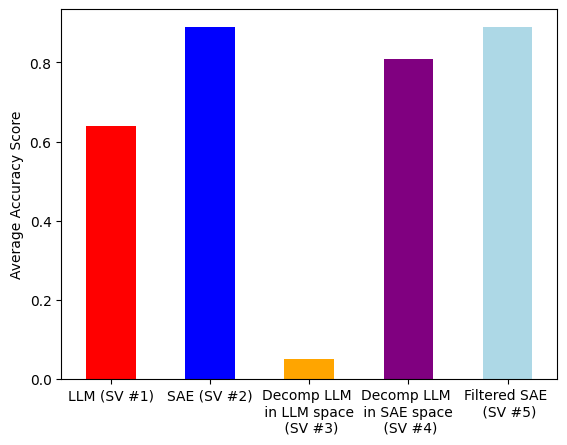

In [ ]:
custom_labels = ['LLM (SV #1)', 'SAE (SV #2)', 'Decomp LLM \n in LLM space \n (SV #3)', 'Decomp LLM \n in SAE space \n (SV #4)', 'Filtered SAE \n (SV #5)']
colors = ['red', 'blue', 'orange', 'purple', 'lightblue']

num_tasks = len(custom_labels)  # Five tasks, one for each color
task_indices = np.arange(num_tasks)
bar_width = 0.5  # A wider bar width for better visual impact

# Create the figure and axes
fig, ax = plt.subplots()

# Plotting the bars
for i in range(num_tasks):
    ax.bar(task_indices[i], avg_scores[i], width=bar_width, label=custom_labels[i], color=colors[i])

# Set labels and titles
ax.set_ylabel('Average Accuracy Score')
ax.set_xticks(task_indices)
ax.set_xticklabels(custom_labels)  # Use color names as x-tick labels

# Adjusting the x-axis limits to space out the x-ticks
ax.set_xlim(-0.5, num_tasks - 0.5)

# Optionally, adding a legend if needed (commented out since it may be redundant)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()

# bar plot all tasks, all sv

In [ ]:
test_labels_lst_2 = ['numwords', 'months', 'days', 'tomorrow_is', 'nextMonth_is', 'descr \n numwords', 'spanish \n numwords']

In [ ]:
get_best_scores_fn(SAE_scores)

[1.0, 1.0, 0.67, 0.8, 1.0, 0.75, 1.0]

In [ ]:
get_best_scores_fn(LLM_scores)

[1.0, 0.2, 0.33, 0.4, 1.0, 0.75, 0.8]

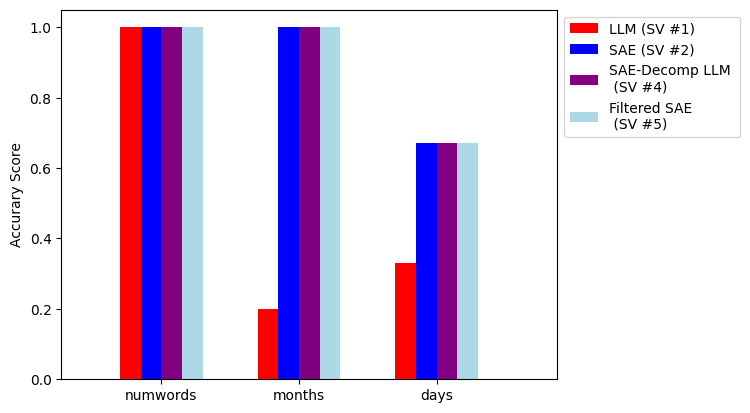

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom colors for each list
colors = ['red', 'blue', 'purple', 'lightblue',] #  'orange'  #cyan

# Custom labels for each list
# custom_labels = ['SAE Model', 'LLM Model', 'LLMsp Ablated', 'SAEsp Ablated', 'Ablated SAE']
custom_labels = ['LLM (SV #1)', 'SAE (SV #2)', 'SAE-Decomp LLM \n (SV #4)', 'Filtered SAE \n (SV #5)']

scores = [
    get_best_scores_fn(LLM_scores),
    get_best_scores_fn(SAE_scores),
    # get_best_scores_fn(LLMsp_abl_LLM_scores),
    get_best_scores_fn(SAEsp_abl_LLM_scores),
    get_best_scores_fn(abl_SAE_scores)
]

num_lists = len(scores)
num_tasks = 3  # plot the first 3 tasks

task_indices = np.arange(num_tasks) # position of the groups of bars

bar_width = 0.15 #  width of a single bar

fig, ax = plt.subplots()
for i in range(num_lists):
    ax.bar(task_indices + i * bar_width, [scores[i][j] for j in range(num_tasks)],
           width=bar_width, label=custom_labels[i], color=colors[i])

ax.set_ylabel('Accurary Score')
# ax.set_title()
ax.set_xticks(task_indices + bar_width * (num_lists - 1) / 2)
ax.set_xticklabels([test_labels_lst[i] for i in range(num_tasks)])  # Adjusted for the first three tasks only

# legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# space out the x-ticks
ax.set_xlim(-0.5, num_tasks - 0.5 + num_lists * bar_width)  # Adjusting x-limits to provide a better spaced view

plt.show()

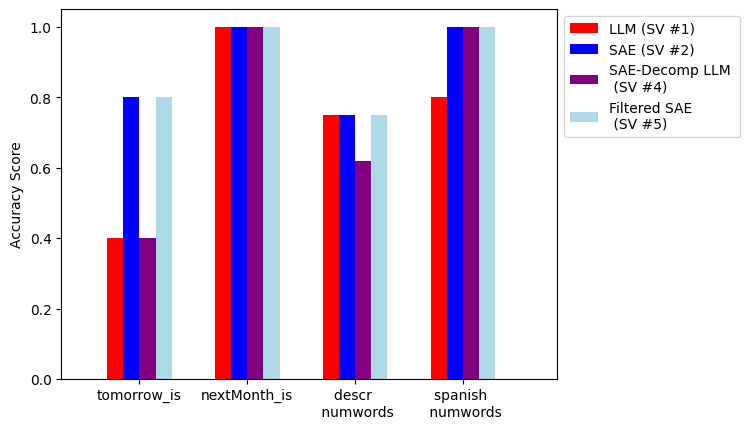

In [ ]:
num_lists = len(scores)
num_tasks = 4  # plot the last 4 tasks

task_indices = np.arange(num_tasks)

bar_width = 0.15

fig, ax = plt.subplots()

for i in range(num_lists):
    ax.bar(task_indices + i * bar_width, [scores[i][j + 3] for j in range(num_tasks)],
           width=bar_width, label=custom_labels[i], color=colors[i])

ax.set_ylabel('Accuracy Score')
# ax.set_title('')
ax.set_xticks(task_indices + bar_width * (num_lists - 1) / 2)
ax.set_xticklabels([test_labels_lst_2[i + 3] for i in range(num_tasks)])  # for the last four tasks only

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.set_xlim(-0.5, num_tasks - 0.5 + num_lists * bar_width)

plt.show()